In [2]:
# -*- coding: utf-8 -*-

import mdshare
import mdtraj as md
import nglview as ng
import numpy as np

from torch.utils import data
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import glob

import torch
from torch import nn 
from argparse import ArgumentParser

from denoising_diffusion_pytorch import Unet, GaussianDiffusion, Trainer, Dataset_traj, cycle, num_to_groups

import sys, os
sys.path.append('./denoising_diffusion_pytorch')

from Unets_MJ import Unet_xyz
from denoising_diffusion_pytorch_MJ import Unet, GaussianDiffusion
from denoising_diffusion_pytorch_1d_MJ import Unet1D

device =  torch.device("cuda")  #torch.device("cpu")
parser = ArgumentParser()

folder_name = 'traj_AIB9'
train_name = 'train_pep_AA-heavy'
cond_name = 'train_pep_AA-heavy_cond'
test_name = 'test_pep_AA-heavy'
model_name = 'Unet1D'
n_srvs = 4
model_train_steps = 2000000
save_name = 'AA-heavy_Unet1D_2000000s'
n_atoms = 94
loss = 'l1'
beta = 'cosine'

urandom = False
usinu = False
uself = False

dtime = 1000
init_dim = 32

dim_mults = (1, 2, 4, 8) #(1, 2, 2, 4)
train_batch_size = 128

print(save_name)

if model_name =='Unet':
    model = Unet(dim = init_dim, dim_mults = dim_mults, groups = 8).to(device) #(1, 2, 2, 4)
    
elif model_name == 'Unet_xyz':
    model =  Unet_xyz(dim = init_dim, n_conds=n_srvs, dim_mults = dim_mults, groups = 8).to(device)
    
elif model_name == 'Unet_cond':
    model = Unet_cond(dim = init_dim, n_conds=n_srvs, dim_mults = dim_mults, groups = 8).to(device)
    
elif model_name == 'Unet1D':
    model = Unet1D(dim = init_dim, dim_mults = dim_mults, channels=1,     
              self_condition=uself, random_fourier_features=urandom, 
              learned_sinusoidal_cond=usinu, learned_sinusoidal_dim=16) 
    
op_num = n_atoms*3 + n_srvs     
konw_op_num = n_srvs

print('Before sent to device')

model = nn.DataParallel(model)
model.to(device)

print('After sent to device')

diffusion = GaussianDiffusion(
    model,                          # U-net model
    timesteps = dtime,               # number of diffusion steps
    unmask_number = konw_op_num,    # konw_op_num,  # the dimension of x2 in P(x1|x2)
    loss_type = loss,    #'l2'           # L1 or L2
    beta_schedule = beta
).to(device) 

#set training parameters
trainer = Trainer(
    diffusion,                                   # diffusion model
    folder = folder_name,                        # folder of trajectories
    system = train_name,         
    train_batch_size = 128,                      # training batch size
    train_lr = 1e-5,                             # learning rate
    train_num_steps = model_train_steps,       # total training steps
    gradient_accumulate_every = 1,               # gradient accumulation steps
    ema_decay = 0.995,                           # exponential moving average decay
    op_number = op_num,
    fp16 = False,
    save_name = save_name, # turn on mixed precision training with apex
)

# find last milestone
model_list = sorted(glob.glob(f'{trainer.RESULTS_FOLDER}/model-??.pt'))
last_milestone = max([int(m.split('/')[-1].replace('.pt', '').replace('model-', '')) for m in model_list])

# start load last 
trainer.load(last_milestone)


AA-heavy_Unet1D_2000000s
Before sent to device
After sent to device


In [3]:
# save conditions from first frame

repeat_dims = 1000
frame_idxs = [0, 4943, 3393, 19625]

for frame_idx in frame_idxs:

    og_conds = np.load('./traj_AIB9/test_pep_AA-heavy_cond_traj.npy')

    single_conds = np.repeat(og_conds[frame_idx][np.newaxis, :], repeat_dims, axis=0)

    single_cond_name = f'test_pep_AA-heavy_single-{frame_idx}'
    np.save(f'./traj_AIB9/{single_cond_name}_traj.npy', single_conds)


    print(og_conds.shape, single_conds.shape)



(25005, 4) (1000, 4)
(25005, 4) (1000, 4)
(25005, 4) (1000, 4)
(25005, 4) (1000, 4)


In [3]:

#prepare a dataloader to give samples from the conditional part of the distribution
batch_size = 5000  #1280  #the number of samples generated in each batch

for frame_idx in frame_idxs:

    single_cond_name = f'test_pep_AA-heavy_single-{frame_idx}'
    
    sample_ds = Dataset_traj(folder_name,  single_cond_name, n_conds=konw_op_num) 
    sample_ds.max_data = trainer.ds.max_data
    sample_ds.min_data = trainer.ds.min_data    #To ensure that the sample data is scaled in the same way as the training data

    # both shuffle and pin_memory og set to true
    sample_dl = cycle(data.DataLoader(sample_ds, batch_size = batch_size, shuffle=False, pin_memory=False)) 

    # generate samples and save -- is this best way to do it?
    num_sample = sample_ds.data.shape[0] # total number of samples

    batches = num_to_groups(num_sample, batch_size)
    all_ops_list = list(map(lambda n: trainer.ema_model.sample(
        trainer.op_number, batch_size=n, samples = next(sample_dl).cuda()[:n, :]), batches))

    all_ops = torch.cat(all_ops_list, dim=0).cpu()
    all_ops = trainer.rescale_sample_back(all_ops)

    np.save(str(trainer.RESULTS_FOLDER / f'samples_single-{frame_idx}'), all_ops.numpy())
    
    break

sampling loop time step:   1%|          | 9/1000 [00:07<14:34,  1.13it/s]  


KeyboardInterrupt: 

In [4]:
# load select frame into structures

frame_idx = 0

n_srv = 4
n_atoms = 94

# load in original training
pdb = mdshare.fetch('pentapeptide-impl-solv.pdb', working_directory='data_mdshare')
files = mdshare.fetch('pentapeptide-*-500ns-impl-solv.xtc', working_directory='data_mdshare')
synth_name = glob.glob(f'./results/{train_name}/*/*Unet1D*2000000s/samples_single-{frame_idx}*')[0]
print(synth_name)

trj = md.load(files, top=pdb)
trjs = [md.load(file, top=pdb) for file in files]

heavy_idxs = trj.top.select_atom_indices('heavy')
heavy_trj = trj.atom_slice(heavy_idxs) 
heavy_trj = heavy_trj.superpose(heavy_trj)
heavy_trjs = [t.atom_slice(heavy_idxs) for t in trjs]

# load test samples
test_r = np.load(f'./traj_AIB9/{test_name}_traj.npy')
test_r = test_r[:, n_srvs:].reshape((-1, n_atoms, 3))
trj_aa_r = md.Trajectory(test_r, topology=trj.top)
trj_r = trj_aa_r.atom_slice(heavy_idxs)

# load synth
test_s = np.load(synth_name)
test_s = np.squeeze(test_s)[:, n_srvs:].reshape((-1, n_atoms, 3))
print(test_s.shape)

trj_aa_s = md.Trajectory(test_s, topology=trj.top)
trj_s = trj_aa_s.atom_slice(heavy_idxs)



./results/train_pep_AA-heavy/32-1-2-4-8-b128/AA-heavy_Unet1D_2000000s/samples_single-0.npy
(1000, 94, 3)


In [5]:

from nglview import NGLWidget

view = NGLWidget() 
view.add_trajectory(trj_r[frame_idx])
view.add_trajectory(trj_s)

op_list = [0.4, 1.0]
for v, op in zip(view, op_list):
    v.clear_representations()
    v.add_representation('ball+stick', opacity=op)
view

NGLWidget(max_frame=999)

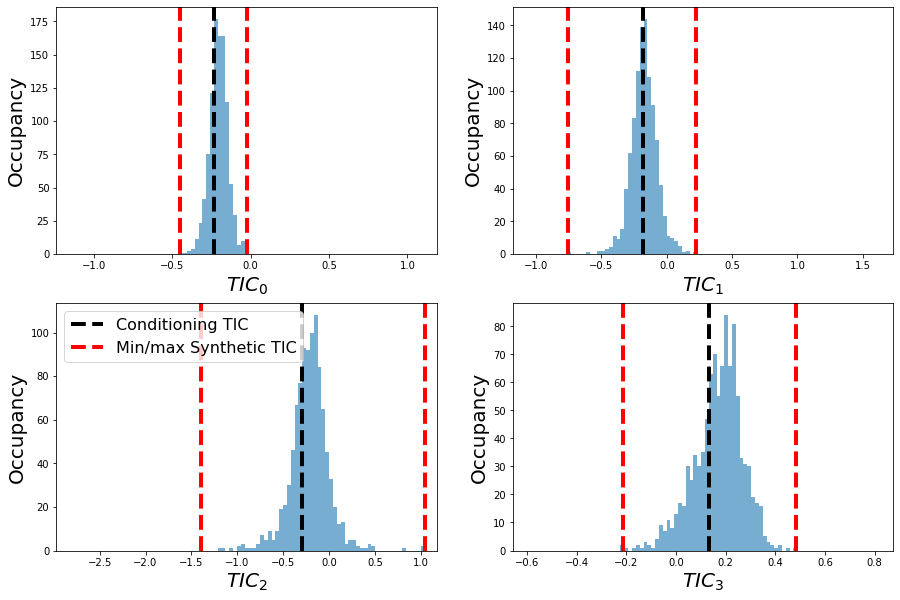

In [24]:
# plot distributions of different noise relative to the conditioning values

import pickle as pkl
from scipy.spatial.distance import pdist

# load tica object and real coords
TICA = pkl.load(open(f'./traj_AIB9/tica_pep_AA-heavy.pkl', 'rb'))
TICS_real = np.load('./traj_AIB9/test_pep_AA-heavy_cond_traj.npy')

pdists_noise = np.concatenate([pdist(xyz)[None] for xyz in trj_s.xyz])
TICS_noise = TICA.transform(pdists_noise) 

# consistent
xlim_list = [
    (-1.2398181140422821, 1.1872216641902924), 
    (-1.1780646562576294, 1.7343915224075317), 
    (-2.9715616583824156, 1.1730079531669617),
    (-0.6577425241470337, 0.8756436347961426), 
]

fig, axes = plt.subplots(2,2, figsize=(15, 10))
axes = axes.flatten()
for i, ax in enumerate(axes):
    
    xlims = xlim_list[i]
    bins = np.linspace(xlims[0], xlims[1], 100)
    
    ax.hist(TICS_noise[:,i], bins=bins, alpha=0.6)
    ax.axvline(x=TICS_real[frame_idx][i], c='k', linestyle='--', linewidth=4, label='Conditioning TIC')
    
    ax.axvline(x=np.min(TICS_noise[:,i]), c='r', linestyle='--', linewidth=4)
    ax.axvline(x=np.max(TICS_noise[:,i]), c='r', linestyle='--', linewidth=4, label='Min/max Synthetic TIC')
    
    ax.set_xlabel(f'$TIC_{i}$', fontsize=20)
    ax.set_ylabel('Occupancy', fontsize=20)
    ax.set_xlim(xlim_list[i])
    
axes[2].legend(fontsize=16)


In [14]:
# extract a frame from each step in the diffusion process

# load raw states
d_prog = np.load('./results/train_pep_AA-heavy/32-1-2-4-8-b128/AA-heavy_Unet1D_2000000s/diff_progess.npy')
print(d_prog.shape)

# rescale samples
d_prog = trainer.rescale_sample_back(d_prog[:, 0, :, :])
print(d_prog.shape)

# convert to xyz shape
d_prog = np.squeeze(d_prog)[:, n_srvs:].reshape((-1, n_atoms, 3))
print(d_prog.shape)

trj_last = md.Trajectory(d_prog[-1], topology=trj.top)
trj_prog = md.Trajectory(d_prog, topology=trj.top)

view = NGLWidget() 
view.add_trajectory(trj_last)
view.add_trajectory(trj_prog)

op_list = [0.4, 1.0]
rep_list = ['ball+stick', 'hyperball']

for v, rep, op in zip(view, rep_list, op_list):
    v.clear_representations()
    v.add_representation(rep, opacity=op)
view

(1000, 1, 1, 286)
(1000, 1, 286)
(1000, 94, 3)


NGLWidget(max_frame=999)

In [ ]:
# videos:

# 3x each validation set

# 